# Metropolis Hastings Demo

This notebook demonstrates a simple implementation of the Metropolis-Hastings algorithm for Markov-Chain Monte-Carlo (MCMC) sampling. We follow similar notation as in [Robert & Casella (2010) - Introducing Monte Carlo Methods with R](https://doi.org/10.1007/978-1-4419-1576-4).



Suppose we have a multivariate density $f\left(\mathbf{x}\right)$ known up to a proportionality constant (called the *target density*) we want to sample from, but it is not practical to do so (eg. it has no analytical form and we can only evaluate it). To perform MCMC sampling from this density, then we require a *proposal density*, which is a conditional density $q\left(\mathbf{y}\middle|\mathbf{x}\right)$. The only two conditions we need for this density are that:
* we can easily draw samples from $q$ given $\mathbf{x}$, and that 
* $q$ 'supports' $f$ (roughly speaking, anything that can be sampled from $f$ should also be able to be sampled from $q$).

The Metropolis Hastings algorithm constructs a Markov chain such that the stationary distribution is the same as $f$. The transition law for the chain, given $\mathbf{x}_{t}$, is
1. Sample $\mathbf{Y}_{t} \sim q\left(\mathbf{y}\middle| \mathbf{x}_{t}\right)$

2. Generate $U$ from the uniform distribution on $\left(0, 1\right)$ and take

 \begin{equation}
 \mathbf{X}_{t} = \begin{cases} \mathbf{Y}_{t}, & U \leq \rho\left(\mathbf{x}_{t}, \mathbf{Y}_{t}\right) \\ \mathbf{x}_{t}, & \text{otherwise}\end{cases}
 \end{equation}
 
 with acceptance probability
 \begin{equation}
 \rho\left(\mathbf{x}, \mathbf{y}\right) = \min\left\{\dfrac{f\left(\mathbf{y}\right)}{f\left(\mathbf{x}\right)}\cdot\dfrac{q\left(\mathbf{x}\middle|\mathbf{y}\right)}{q\left(\mathbf{y}\middle|\mathbf{x}\right)}, 1\right\}
 \end{equation}

Then a practical way to draw samples from $f$ is to simulate the chain for a 'reasonably long time'. Then the final sample in the chain will be approximately distributed as $f$. If we want to take $n$ independent samples, then we perform $n$ independent simulated chains and take the last sample in each. For some purposes (eg. plotting a histogram), it is enough to take all the samples in a single chain, even though the samples will be dependent.

As an example, suppose $\mathbf{x} \in \mathbb{R}^{2}$ and we want to sample from the density proportial to
\begin{equation}
f\left(\mathbf{x}\right) = \mathbb{I}_{\left\{x_{1}x_{2} \leq 0 \right\}}\phi\left(x_{1}\right)\phi\left(x_{2}\right)
\end{equation}
where $\phi$ is the standard univariate Gaussian density, and $\mathbb{I}$ is the indicator. This represents the standard bivariate Gaussian truncated on two quadrants. A simple choice of the proposal density is the un-truncated bivariate gaussian:
\begin{equation}
q\left(\mathbf{y}\middle|\mathbf{x}\right) = \phi\left(y_{1}\right)\phi\left(y_{2}\right)
\end{equation}

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm

In [7]:
def fdensity(x):
    #target density
    return (x[0]*x[1] <= 0)*norm.pdf(x[0])*norm.pdf(x[1])

def qdensity(y, x):
    #proposal density
    return norm.pdf(y[0])*norm.pdf(y[1])

def genq(xt):
    #generate sample from proposal density conditional on xt
    return np.random.normal(size = 2)

def mh_draw_sample(xt, f, q, genq):
    #generate the next sample in the Markov chain given xt
    Y = genq(xt)
    
    acceptance_prob = min(f(Y)*q(xt, Y)/(f(xt)*q(Y, xt)), 1)
    
    if (np.random.rand() < acceptance_prob):
        Xtp1 = Y
    else:
        Xtp1 = xt
        
    return Xtp1

In [41]:
#simulate a chain

Nsim = 100000

Xchain = np.zeros((2, Nsim))

for t in range(1, Nsim):
    Xchain[:, t] = mh_draw_sample(Xchain[:, t - 1], fdensity, qdensity, genq)
    


We can visualise the density of the sampled chain, as the standard bivariate Gaussian truncated on two quadrants.

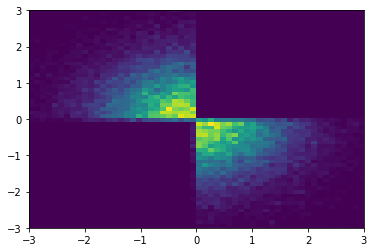

In [44]:
plt.figure()
plt.hist2d(Xchain[0, :], Xchain[1, :], bins=80)
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.show()

## Metropolis Hasings with Logs

To avoid numerical precision issues, we can work with logs in the acceptance rule by noting that
\begin{equation}
\dfrac{f\left(\mathbf{y}\right)}{f\left(\mathbf{x}\right)}\cdot\dfrac{q\left(\mathbf{x}\middle|\mathbf{y}\right)}{q\left(\mathbf{y}\middle|\mathbf{x}\right)} = \exp\left[\log f\left(\mathbf{y}\right) + \log q\left(\mathbf{x}\middle|\mathbf{y}\right) - \log f\left(\mathbf{x}\right) - \log q\left(\mathbf{y}\middle|\mathbf{x}\right)\right]
\end{equation}

In [47]:
def logfdensity(x):
    #log target density
    return np.log((x[0]*x[1] <= 0)*norm.pdf(x[0])*norm.pdf(x[1]))

def logqdensity(y, x):
    #log proposal density
    return np.log(norm.pdf(y[0])*norm.pdf(y[1]))

def mh_draw_sample_log(xt, logf, logq, genq):
    #generate the next sample in the Markov chain given xt and log densities
    Y = genq(xt)
    
    acceptance_prob = min(np.exp(logf(Y) + logq(xt, Y) - logf(xt) - logq(Y, xt)), 1)
    
    if (np.random.rand() < acceptance_prob):
        Xtp1 = Y
    else:
        Xtp1 = xt
        
    return Xtp1

In [48]:
#simulate a chain using log sampler

Nsim = 100000

Xchain = np.zeros((2, Nsim))

for t in range(1, Nsim):
    Xchain[:, t] = mh_draw_sample_log(Xchain[:, t - 1], logfdensity, logqdensity, genq)
    


C:\Users\rchin2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


This produces the same results as above.

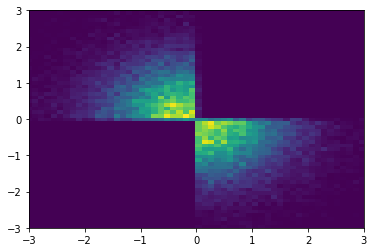

In [49]:
plt.figure()
plt.hist2d(Xchain[0, :], Xchain[1, :], bins=80)
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.show()